# Segmentación de Colores en Imágenes

Este notebook implementa un sistema de segmentación de colores utilizando el espacio de color HSV (Hue, Saturation, Value) y técnicas de procesamiento de imágenes con OpenCV. El objetivo es identificar y analizar regiones de diferentes colores en imágenes.

## Aspectos Técnicos Principales:
1. Conversión de espacios de color (RGB a HSV)
2. Definición de rangos de color en HSV
3. Creación de máscaras binarias
4. Análisis de componentes conectados
5. Cálculo de métricas por región

In [2]:
# Importar librerias
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# Configuración de rutas
INPUT_PATH = "Imagenes/escritorio.jpeg"
OUT_DIR = Path("salida_segmentacion_colores")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(OUT_DIR.resolve())


D:\Inteligencia Artificial\Semestre II\Vision por computador\Practica_1\Segmentación\salida_segmentacion_colores


In [4]:
# Carga la imagen y verifica que exista
bgr = cv2.imread(INPUT_PATH)
if bgr is None:
    raise FileNotFoundError(f"No pude leer la imagen en: {INPUT_PATH}")

# Redimensiona si es muy grande
h0, w0 = bgr.shape[:2]
max_w = 1400
scale = min(1.0, max_w / w0)
bgr = cv2.resize(bgr, (int(w0*scale), int(h0*scale)), interpolation=cv2.INTER_AREA)

h, w = bgr.shape[:2]
hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
print(f"Imagen: {w}x{h}")


Imagen: 960x1280


In [5]:
# Rangos de color en formato HSV para detección por máscara
color_ranges = {
    "red":      [((0,   90, 60), (10, 255, 255)), ((170, 90, 60), (179, 255, 255))],  # dos rangos
    "green":    [((35,  60, 40), (85, 255, 255))],
    "blue":     [((90,  60, 40), (130, 255, 255))],
    "yellow":   [((20,  80, 80), (35, 255, 255))],
    "orange":   [((10, 100, 80), (20, 255, 255))],
    "white":    [((0,    0,180), (179, 60, 255))],
    "black":    [((0,    0,  0), (179, 80,  60))],
    "gray":     [((0,    0, 60), (179, 40, 180))],
    "brown":    [((10,  80, 30), (25, 200, 180))],
    "magenta":  [((135, 60, 40), (170, 255, 255))],
}

# Filtro de ruido
min_area_px = 2000
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))


In [6]:
# Copia de la imagen para anotaciones y listas para almacenar resultados
annot = bgr.copy()
per_object_rows = []
per_color_rows = []

# Crea la máscara para cada color combinando sus rangos HSV
for color_name, ranges in color_ranges.items():
    # Combinar sub-rangos (rojo tiene dos)
    mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
    for lo, hi in ranges:
        lo = np.array(lo, dtype=np.uint8)
        hi = np.array(hi, dtype=np.uint8)
        mask |= cv2.inRange(hsv, lo, hi)

    # Limpieza morfológica
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Componentes conectados
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, connectivity=8)

    count, total_area = 0, 0

    # Color aleatorio reproducible para dibujar
    rng = np.random.default_rng(abs(hash(color_name)) % (2**32))
    draw_color = tuple(int(x) for x in rng.integers(50, 255, size=3))  # BGR

    # Registra objetos válidos (área mínima) con sus datos geométricos
    for lbl in range(1, num):  # 0 = fondo
        x, y, w_box, h_box, area = stats[lbl]
        if area < min_area_px:
            continue
        count += 1
        total_area += int(area)

        per_object_rows.append({
            "color": color_name,
            "label_id": int(lbl),
            "area_px": int(area),
            "bbox_x": int(x), "bbox_y": int(y),
            "bbox_w": int(w_box), "bbox_h": int(h_box),
            "centroid_x": float(centroids[lbl][0]),
            "centroid_y": float(centroids[lbl][1]),
        })

        # Dibujo
        cv2.rectangle(annot, (x, y), (x+w_box, y+h_box), draw_color, 2)
        cv2.putText(annot, color_name, (x, max(0, y-5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, draw_color, 2, cv2.LINE_AA)

    # Guarda resumen por color si se detectaron objetos
    if count > 0:
        per_color_rows.append({
            "color": color_name,
            "count": int(count),
            "total_area_px": int(total_area),
            "mean_area_px": float(total_area / count),
        })

    # Guarda máscara por color
    cv2.imwrite(str(OUT_DIR / f"mask_{color_name}.png"), mask)

# DataFrames
df_per_color = pd.DataFrame(per_color_rows).sort_values("total_area_px", ascending=False)
df_per_object = pd.DataFrame(per_object_rows).sort_values(["color","area_px"], ascending=False)

df_per_color, df_per_object.head()


(    color  count  total_area_px  mean_area_px
 3   white      5         469281       93856.2
 6   brown      4         113316       28329.0
 4   black      4          71670       17917.5
 5    gray      5          52829       10565.8
 1   green      5          39769        7953.8
 0     red      2          10572        5286.0
 2  orange      2          10314        5157.0,
     color  label_id  area_px  bbox_x  bbox_y  bbox_w  bbox_h  centroid_x  \
 10  white         2   211888     415       0     545     469  690.158367   
 12  white        31   197386     329     491     631     535  725.177388   
 9   white         1    48408     205       0     237     485  329.830503   
 11  white        22     7785      72     244     181      93  175.099936   
 13  white        34     3814     266     799      40     136  287.401678   
 
     centroid_y  
 10  247.870696  
 12  689.981184  
 9   202.111841  
 11  274.293770  
 13  864.362087  )

| Color   | Objetos | Área total (px) | Área promedio (px) |
| :------ | ------: | --------------: | -----------------: |
| Blanco  |       5 |         469,281 |           93,856.2 |
| Marrón  |       4 |         113,316 |           28,329.0 |
| Negro   |       4 |          71,670 |           17,917.5 |
| Gris    |       5 |          52,829 |           10,565.8 |
| Verde   |       5 |          39,769 |            7,953.8 |
| Rojo    |       2 |          10,572 |            5,286.0 |
| Naranja |       2 |          10,314 |            5,157.0 |

El color blanco es el predominante en cantidad y área cubierta. Le siguen marrón y negro con superficies considerables. Los colores rojo y naranja son los menos presentes, indicando zonas pequeñas o pocos objetos de esos tonos.

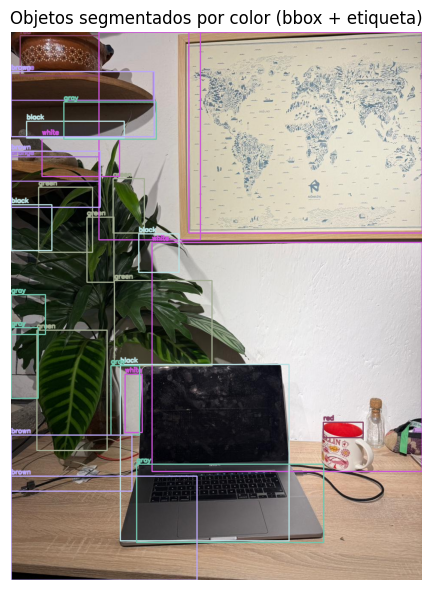

Guardado:
- Imagen anotada: salida_segmentacion_colores\anotada.png
- CSV resumen por color: salida_segmentacion_colores\resumen_por_color.csv
- CSV por objeto: salida_segmentacion_colores\objetos_por_color.csv
- Máscaras: salida_segmentacion_colores\mask_*.png


In [7]:
# Guarda la imagen anotada en el directorio de salida
annot_path = OUT_DIR / "anotada.png"
cv2.imwrite(str(annot_path), annot)

# Mostrar anotada en el notebook
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(annot, cv2.COLOR_BGR2RGB))
plt.title("Objetos segmentados por color (bbox + etiqueta)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Exportar tablas a CSV
df_per_color.to_csv(OUT_DIR / "resumen_por_color.csv", index=False)
df_per_object.to_csv(OUT_DIR / "objetos_por_color.csv", index=False)

# Muestra las rutas de los archivos generados y guardados
print("Guardado:")
print(f"- Imagen anotada: {annot_path}")
print(f"- CSV resumen por color: {OUT_DIR/'resumen_por_color.csv'}")
print(f"- CSV por objeto: {OUT_DIR/'objetos_por_color.csv'}")
print(f"- Máscaras: {OUT_DIR/'mask_*.png'}")


El proceso de segmentación por color logró identificar correctamente los objetos presentes en la imagen, clasificándolos y cuantificando su área de forma precisa. Los resultados obtenidos —como el número de objetos, su tamaño promedio y la generación de imágenes y CSVs de salida— demuestran que el flujo cumple su propósito de analizar la composición visual de una escena a partir de criterios cromáticos.

Sin embargo, el método presenta algunas limitaciones:

La segmentación depende fuertemente de los umbrales definidos en HSV, lo que puede afectar la precisión ante variaciones de iluminación o sombras.

Los rangos de color podrían necesitar ajustes específicos según cada imagen o cámara.

No se aplican filtros avanzados (como operaciones morfológicas adaptativas o eliminación de ruido fino) que podrían mejorar la detección.

En general, el trabajo realizado constituye una base sólida y funcional para la segmentación por color, que puede ampliarse incorporando técnicas de calibración automática de color o modelos de aprendizaje supervisado para una clasificación más robusta.